<a href="https://colab.research.google.com/github/zzhining/time_series_basic/blob/main/stock_market_analysis_prediction_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Analysis 

## 실습목표
----
주식 시장 데이터를 분석(pandas, 시각화)하고, 예측 알고리즘 생성(LSTM)

    1.) 시간에 따라 주가는 어떻게 변하는가?
    2.) 이동평균선
    3.) 일간 평균 수익률은 얼마인가?
    4.) 특정 종목은 다른 종목과 상관관계가 존재하는가?
    5.) 주가를 예측하기 위해서 어떤 특징(feature)을 사용할 수 있을까?
    6.) LSTM을 사용한 APPLE 종가 예측
   

## 0. 환경설정

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 465 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


#### 1) 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yfin

# For time stamps
from datetime import datetime

#### 2) 데이터 불러오기
- globals(): 변수 명을 자동으로 생성하는 함수

In [3]:
yfin.pdr_override()

# 분석할 종목 티커
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# 분석할 기간
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# 분석할 기간 동안의 데이터 읽어오기
for stock in tech_list:
    globals()[stock] = pdr.get_data_yahoo(stock, start = start, end = end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,156.829723,158.971601,154.743834,156.913953,156.412245,8.865151e+07
std,12.894187,12.704496,12.941428,12.840693,12.623887,2.487669e+07
min,130.070007,132.389999,129.039993,130.059998,129.664490,3.519590e+07
25%,145.809998,148.000000,144.179993,146.350006,145.904968,7.159840e+07
50%,156.009995,158.229996,153.610001,156.570007,155.864883,8.444270e+07
75%,168.710007,170.350006,166.559998,167.660004,167.292496,9.794320e+07
max,182.630005,182.940002,179.119995,182.009995,180.959732,1.954327e+08


In [7]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2021-12-14 to 2022-12-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


회사 별 데이터 프레임 합치기회사 이름 컬럼 추가 

In [8]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-12-01,96.989998,97.230003,94.919998,95.500000,95.500000,68488000,AMAZON
2022-12-02,94.480003,95.360001,93.779999,94.129997,94.129997,72427000,AMAZON
2022-12-05,93.050003,94.059998,90.820000,91.010002,91.010002,71535500,AMAZON
2022-12-06,90.500000,91.040001,87.900002,88.250000,88.250000,75503600,AMAZON
2022-12-07,88.339996,89.889999,87.480003,88.459999,88.459999,68086900,AMAZON
2022-12-08,89.239998,90.860001,87.879997,90.349998,90.349998,73305900,AMAZON
2022-12-09,88.900002,90.300003,88.629997,89.089996,89.089996,67316900,AMAZON
2022-12-12,89.209999,90.580002,87.870003,90.550003,90.550003,61999800,AMAZON
2022-12-13,95.230003,96.250000,90.519997,92.489998,92.489998,100212000,AMAZON


## 1. 주가 변화
----

pandas를 사용해서 주가 데이터 탐색을 진행합니다.

#### 1) 최근 1년간 종가 시각화

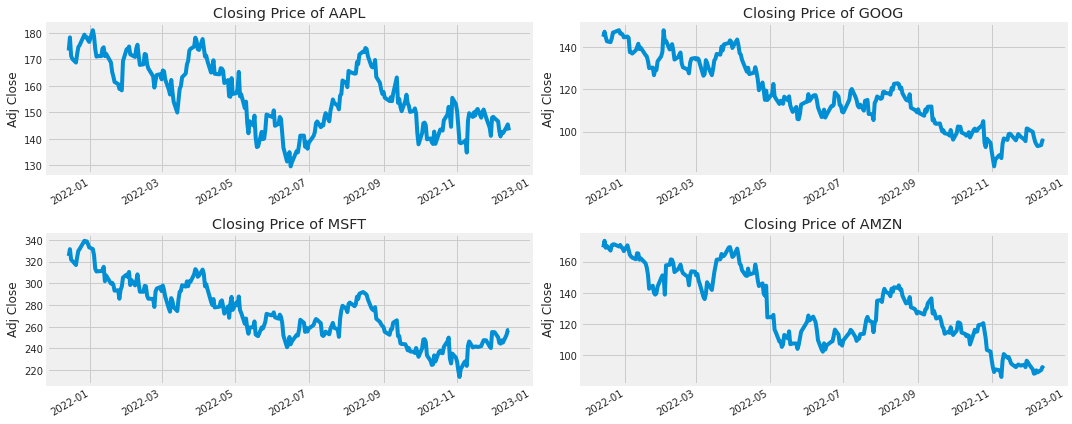

In [9]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

#### 2) 최근 1년간 거래량 시각화

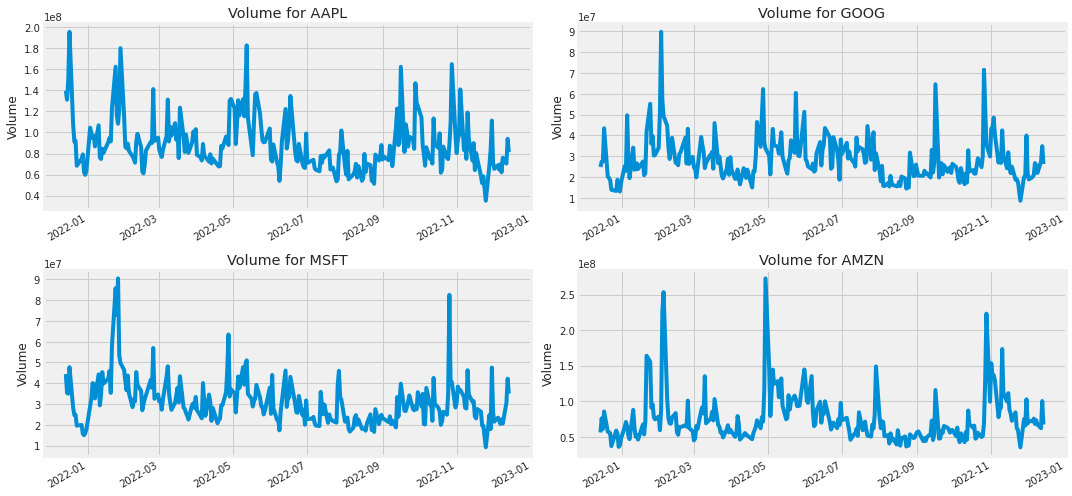

In [10]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 7))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

## 2. 이동평균선(Moving Average)
---
10일, 20일, 50일 이동평균

In [11]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

10일, 20일, 50일 이동평균선

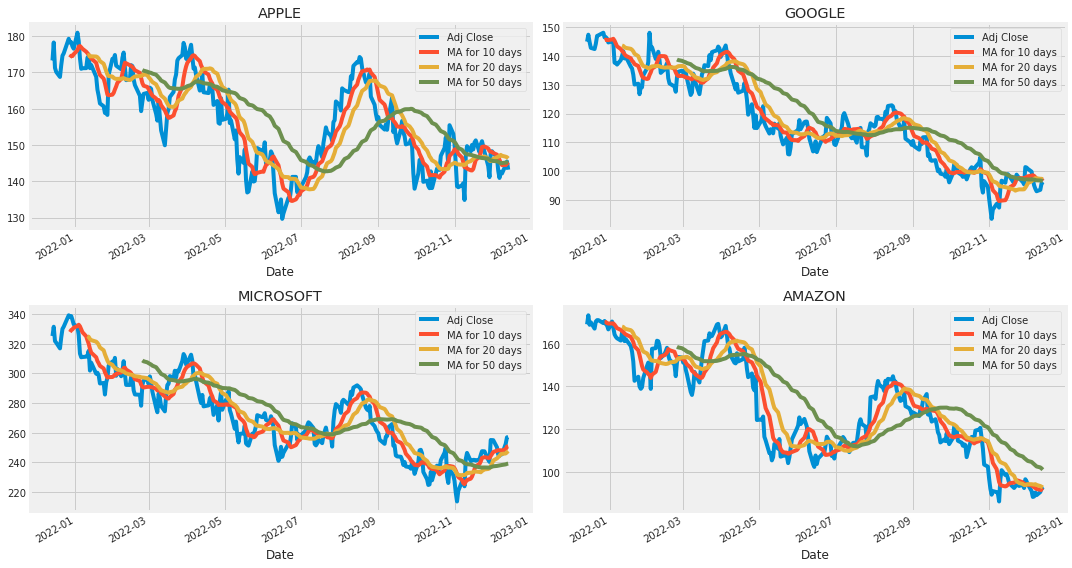

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

## 3. 일자별 수익률(Daily retrun)

일자 별 Daily return

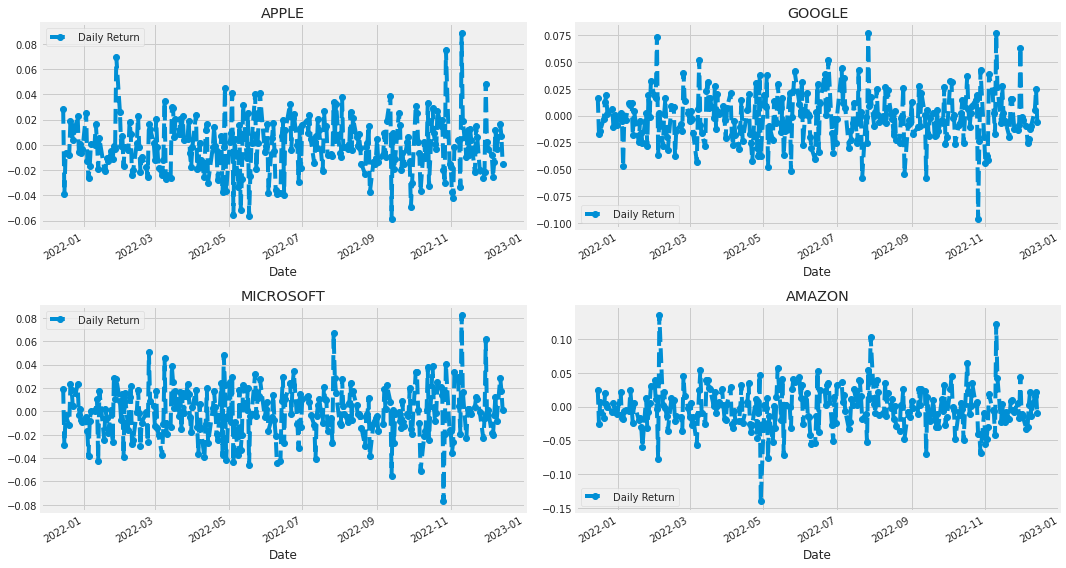

In [15]:
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Daily return의 분포

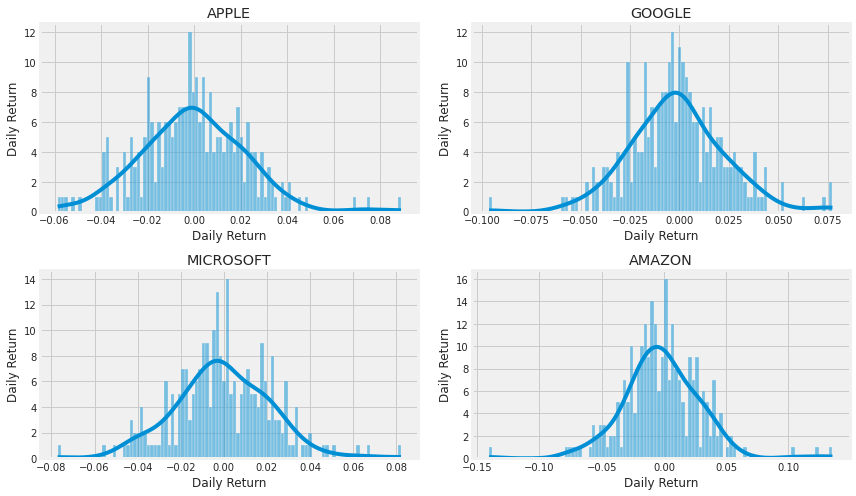

In [19]:
plt.figure(figsize=(12, 7))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.histplot(company['Daily Return'].dropna(), kde = True, bins=100)#, color='purple')
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

## 4. 종목간 상관관계

종목 별 종가(`Adj Close`)기준 상관관계를 확인하기 위해 데이터프레임 생성

In [20]:
closing_df = pdr.get_data_yahoo(tech_list, start = start, end = end)['Adj Close']
closing_df.head() 

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2021-12-14,173.324081,169.091507,144.970505,325.291992
2021-12-15,178.265411,173.315002,147.368500,331.543335
2021-12-16,171.266006,168.871002,144.838501,321.883911
2021-12-17,170.152466,170.017502,142.802994,320.794098
2021-12-20,168.770477,167.078995,142.401505,316.940247


Daily return

In [22]:
tech_rets = closing_df.pct_change()
tech_rets.head()

,AAPL,AMZN,GOOG,MSFT
Date,,,,
2021-12-14,NaN,NaN,NaN,NaN
2021-12-15,0.028509,0.024978,0.016541,0.019218
2021-12-16,-0.039264,-0.025641,-0.017168,-0.029135
2021-12-17,-0.006502,0.006789,-0.014054,-0.003386
2021-12-20,-0.008122,-0.017284,-0.002811,-0.012013


#### 1) 종목별 종가의 Daily Return 상관관계 시각화

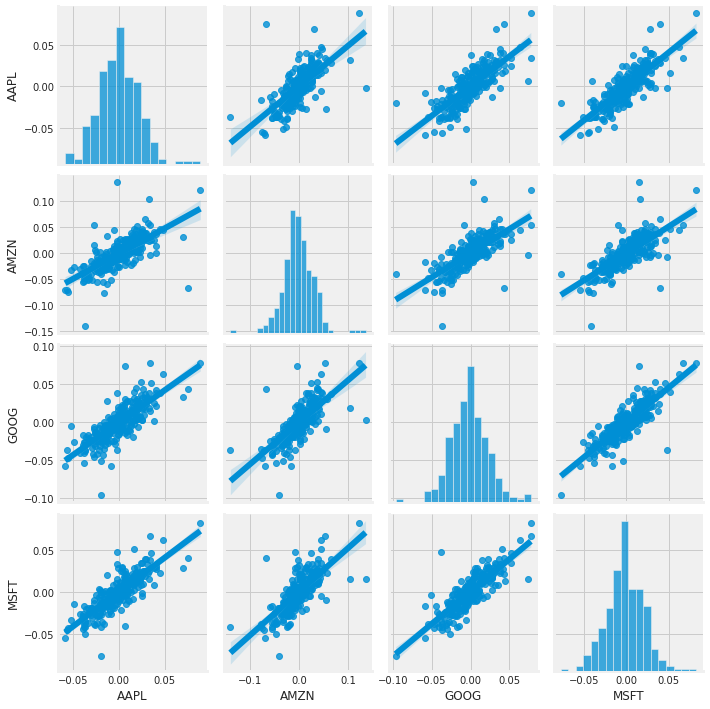

In [23]:
sns.pairplot(tech_rets, kind='reg')

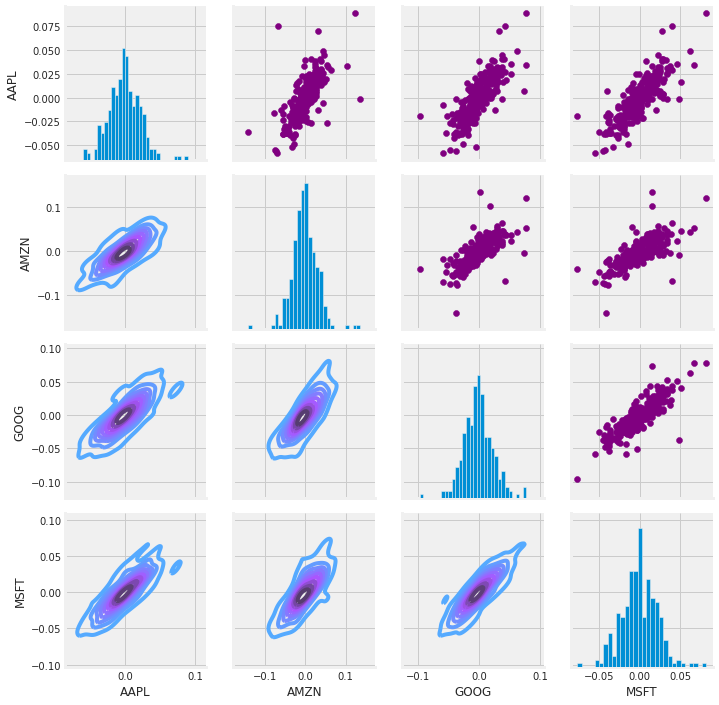

In [24]:
return_fig = sns.PairGrid(tech_rets.dropna())

# PairPlot의 상단부는 산점도
return_fig.map_upper(plt.scatter, color='purple')

# PairPlot의 하단부는 kde plot
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# PairPlot의 대각선은 히스토그램 
return_fig.map_diag(plt.hist, bins=30)

#### 2) 종목별 종가의 상관관계 시각화

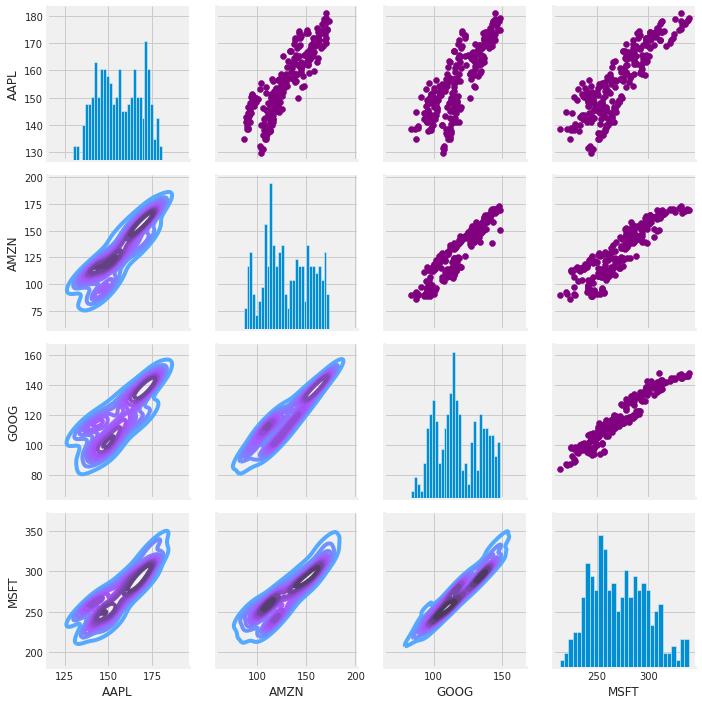

In [30]:
returns_fig = sns.PairGrid(closing_df)

returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

#### 3) 종목별 종가의 Daily Return 상관관계 시각화(Heatmap)

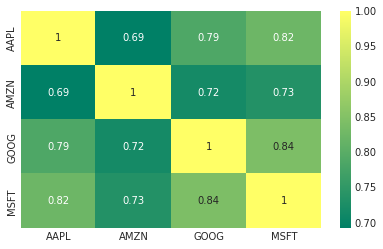

In [26]:
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

#### 4) 종목별 종가의 상관관계 시각화(Heatmap)

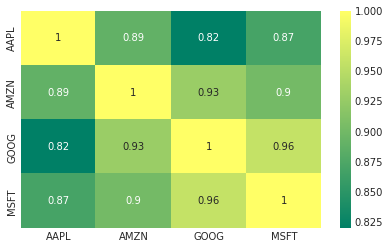

In [27]:
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')

모든 기술 회사가 양의 상관 관계를 갖고 있음

## 5. 기대수익률

기대수익률의 평균값과 표준편차 시각화

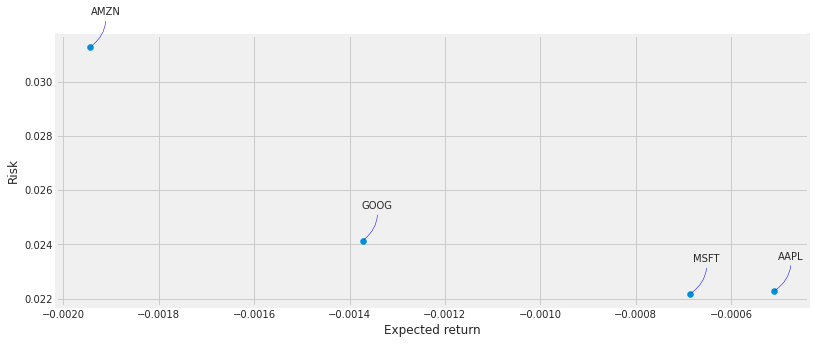

In [82]:
rets = tech_rets.dropna()

plt.figure(figsize=(12, 5))
plt.scatter(rets.mean(), rets.std())
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(30, 30), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

## 6. APPLE 주가 예측하기
----
최근 10년 동안의 APPLE 주가를 바탕으로 주가 예측

#### 1) 데이터 불러오기

In [33]:
df = pdr.get_data_yahoo('AAPL', start = '2012-01-01', end = end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.519280,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.586555,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.726294,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.859330,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.838937,394024400


#### 2) 데이터 탐색

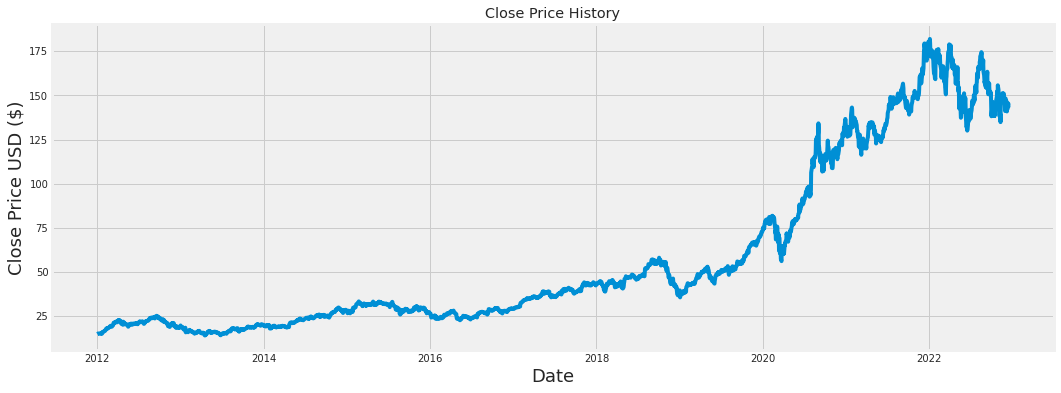

In [34]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

#### 3) 데이터 전처리 - Scale

In [65]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.filter(['Close']).values)

scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.77674978],
       [0.78258092],
       [0.76913357]])

#### 4) 데이터 분할

In [36]:
# 전체 데이터 셋의 95%는 학습용으로 사용
training_data_len = int(np.ceil( len(scaled_data) * .95 ))
training_data_len

2620

In [44]:
train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - 60: , :]

x_train, y_train = [], []
x_test = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #[0:60]
    y_train.append(train_data[i, 0]) #[60]
        
# Create the data sets x_test and y_test
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

y_test = df.filter(['Close']).values[training_data_len:, :]
    
# Convert the x_train and y_train to numpy arrays 
x_train, y_train, x_test = np.array(x_train), np.array(y_train), np.array(x_test)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [46]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2560, 60, 1), (2560,), (137, 60, 1), (137, 1))

#### 5) 학습 - 신경망(LSTM)

In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2560/2560 [==============================] - 113s 43ms/step - loss: 0.0014


#### 6) 예측

In [47]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 39ms/step


5.8814438879798905

<ipython-input-48-427af188b99b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


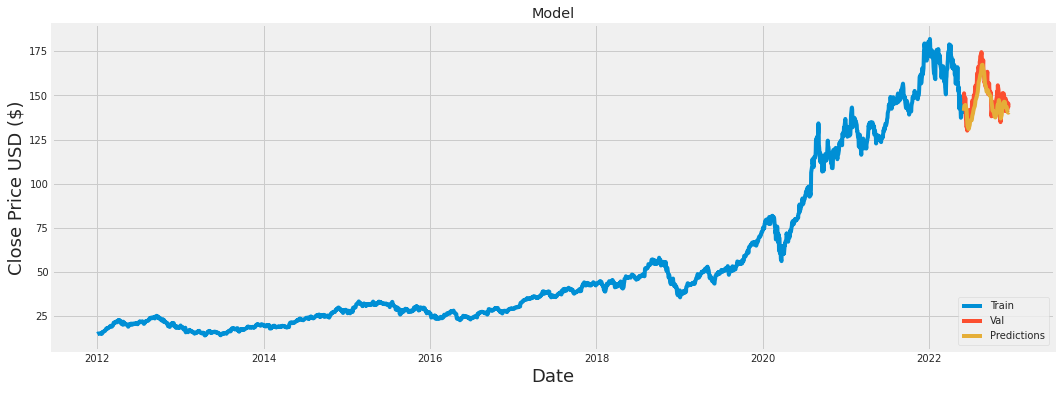

In [48]:
# Plot the data
data = df.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [49]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2022-06-01,148.710007,141.280899
2022-06-02,151.210007,142.640289
2022-06-03,145.380005,144.076065
2022-06-06,146.139999,144.379486
2022-06-07,148.710007,144.294861
...,...,...
2022-12-08,142.649994,141.799301
2022-12-09,142.160004,140.990967
2022-12-12,144.490005,140.321365


<ipython-input-51-4fee773dcfe1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['diff'] = valid['Close'] - valid['Predictions']


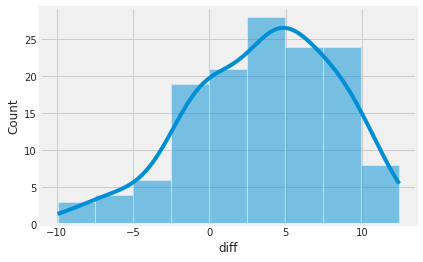

In [51]:
valid['diff'] = valid['Close'] - valid['Predictions']
sns.histplot(valid['diff'], kde=True)

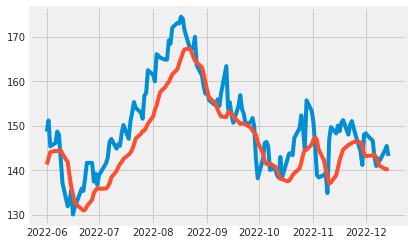

In [52]:
plt.plot(valid[['Close', 'Predictions']])